In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

/Users/seohyunkim/anaconda2/envs/PythonData/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


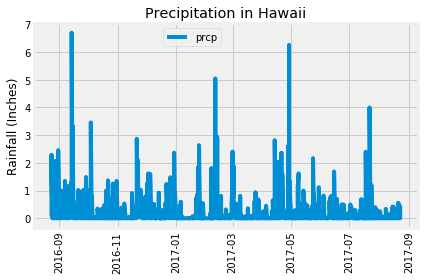

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

recent_date = session.query(measurement).order_by(measurement.date.desc()).limit(1)
    
for date in recent_date:
    most_recent_date = date.date

most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")


# Calculate the date 1 year ago from today

one_year_ago = most_recent_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

recent_prcp_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(recent_prcp_data).dropna()

# Sort the dataframe by date

df['date'] = pd.to_datetime(df['date'])


# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(df['date'], df['prcp'])
plt.title("Precipitation in Hawaii")
#plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(bbox_to_anchor=(0.5, 1.00))

# Rotate the xticks for the dates
plt.xticks(rotation='90')

plt.tight_layout()
plt.show()
#fig = plt.figure()
#plt.savefig("Images/Precipitation.png")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
stations = session.query(measurement.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
stationCounts = (session.query(measurement.station, func.count(measurement.station))
                        .group_by(measurement.station)
                        .order_by(func.count(measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
#set the most active station
stationID = stationCounts[0][0]

#query for station name
stationName = (session.query(station.name)
                      .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")

#query for highest temperature
highestTemp = (session.query(measurement.tobs)
                      .filter(measurement.station == stationID)
                      .order_by(measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded there is {highestTemp} degrees Farenheit.")

#query for lowest temperature
lowestTemp = (session.query(measurement.tobs)
                     .filter(measurement.station == stationID)
                     .order_by(measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded there is {lowestTemp} degrees Farenheit.")

#query for average temperature
avgTemp = (session.query(func.avg(measurement.tobs))
                  .filter(measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature recorded there is 85.0 degrees Farenheit.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


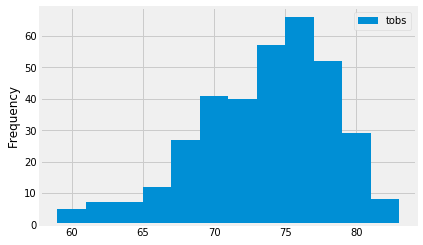

In [15]:
#query for the last year of temperature data
tempData = (session.query(measurement.date, measurement.tobs)
                   .filter(measurement.date > one_year_ago)
                   .filter(measurement.station == stationID)
                   .order_by(measurement.date)
                   .all())

#convert query object to data frame
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

#sory by date
tempTable = tempTable.sort_index(ascending=True)

#histogram plot with pandas
tempTable.plot(kind='hist', bins=12)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
#set trip dates and previous dates
trip = '2019-04-08 to \n 2019-04-19'
tripStartDate = '2017-04-08'
tripEndDate = '2017-04-19'

#calculate the tmin, tavg, and tmax 
tripTemps = calc_temps(tripStartDate, tripEndDate)

tripTemps

[(67.0, 73.6, 83.0)]

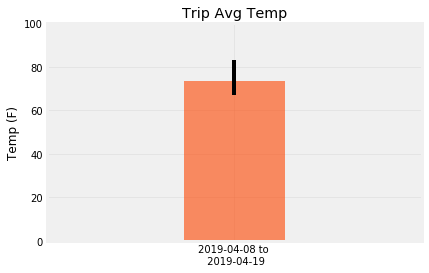

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [19]:
#query for precipitation per station on trip dates
sel = ([station.station, 
        station.name, 
        func.sum(measurement.prcp), 
        station.latitude, 
        station.longitude, 
        station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(station.station == measurement.station)
                   .filter(measurement.date >= tripStartDate)
                   .filter(measurement.date <= tripEndDate)
                   .group_by(station.station)
                   .order_by(func.sum(measurement.prcp).desc())
                   .all())

#convert query object to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))
#rename columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.38,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",6.979999999999999,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.48,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.86,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.8099999999999999,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.31000000000000005,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
#set the start and end date for the trip
startDate = "2019-04-08"
endDate = "2019-04-19"

#calculate trip length
startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1

#start date as datetime object
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')
#list dates (MM-DD) of trip
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

#calculate normals for each date
tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)],
 [(65.0, 72.49180327868852, 82.0)],
 [(65.0, 72.22413793103448, 80.0)],
 [(64.0, 71.52542372881356, 79.0)],
 [(65.0, 72.75, 81.0)],
 [(61.0, 71.79310344827586, 79.0)],
 [(62.0, 71.55357142857143, 81.0)],
 [(65.0, 71.93103448275862, 77.0)],
 [(67.0, 72.49152542372882, 77.0)],
 [(65.0, 72.42105263157895, 83.0)]]

In [22]:
#extract normals into a list of lists
tripNormals = [np.array(normal[0]) for normal in tripNormals]

#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)
#add date column
normalsTable["Date"] = dateList
#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable


,Low Temp,Avg Temp,High Temp
Date,,,
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0


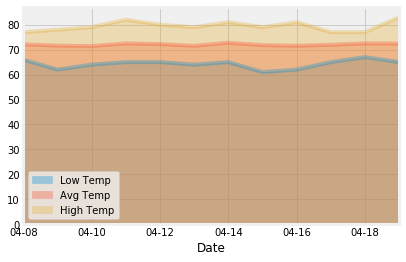

In [23]:
#plot with pandas
normalsTable.plot.area(stacked=False, alpha=.333)